# Topic predicton on Reutuers Dataset

create a model that predicts the topic / topics of the given text

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("Reuters/reuters21578_news.csv")
dataset.head()

,Unnamed: 0,newID,oldID,title,author,data_split,isTopicsAvailable,document_date,dateline,people,places,orgs,exchanges,topic_body,topics
0,0,1,5544,BAHIA COCOA REVIEW,NaN,TRAIN,YES,26-FEB-1987 15:01:01.79,"SALVADOR, Feb 26 -",[],"['el-salvador', 'usa', 'uruguay']",[],[],Showers continued throughout the week in\nthe ...,['cocoa']
1,1,2,5545,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,NaN,TRAIN,NO,26-FEB-1987 15:02:20.00,"CLEVELAND, Feb 26 -",[],['usa'],[],[],Standard Oil Co and BP North America\nInc said...,NaN
2,2,3,5546,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,NaN,TRAIN,NO,26-FEB-1987 15:03:27.51,"HOUSTON, Feb 26 -",[],['usa'],[],[],Texas Commerce Bancshares Inc's Texas\nCommerc...,NaN
3,3,4,5547,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,"by Janie Gabbett, Reuters",TRAIN,NO,26-FEB-1987 15:07:13.72,"LOS ANGELES, Feb 26 -",[],"['usa', 'brazil']",[],[],BankAmerica Corp is not under\npressure to act...,NaN
4,4,5,5548,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,NaN,TRAIN,YES,26-FEB-1987 15:10:44.60,"WASHINGTON, Feb 26 -",[],['usa'],[],[],The U.S. Agriculture Department\nreported the ...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's..."


In [2]:
data = dataset[["title", "topic_body", "topics"]].rename(columns={"topic_body": "text"})
data = data.drop(axis=1, columns=["title"])
data = data.dropna()
print(f"amount of documents: {len(data)}")
data["length"] = data["text"].apply(len)
data.head()

amount of documents: 10377


,text,topics,length
0,Showers continued throughout the week in\nthe ...,['cocoa'],2859
4,The U.S. Agriculture Department\nreported the ...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",1140
5,Argentine grain board figures show\ncrop regis...,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",1263
8,Champion Products Inc said its\nboard of direc...,['earn'],339
9,Computer Terminal Systems Inc said\nit has com...,['acq'],1263


In [3]:
## preprocessing text
import string
import wordninja
exculude = string.punctuation
# to lowercase
data["text"] = data["text"].str.lower()
# remove newline, tabs, numbers
data["text"] = data["text"].replace('[\n\t\'0-9]', '', regex=True)
# remove puncutation
data["text"] = data["text"].apply(lambda s: s.translate(str.maketrans('', '', exculude)))
# split joined words
data["text"] = data["text"].apply(lambda s: " ".join(wordninja.split(s)))
data.head()

,text,topics,length
0,showers continued throughout the week in the b...,['cocoa'],2859
4,the us agriculture department reported the far...,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",1140
5,argentine grain board figures show crop regist...,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",1263
8,champion products inc said its board of direct...,['earn'],339
9,computer terminal systems inc said it has comp...,['acq'],1263


<Axes: xlabel='length', ylabel='count'>

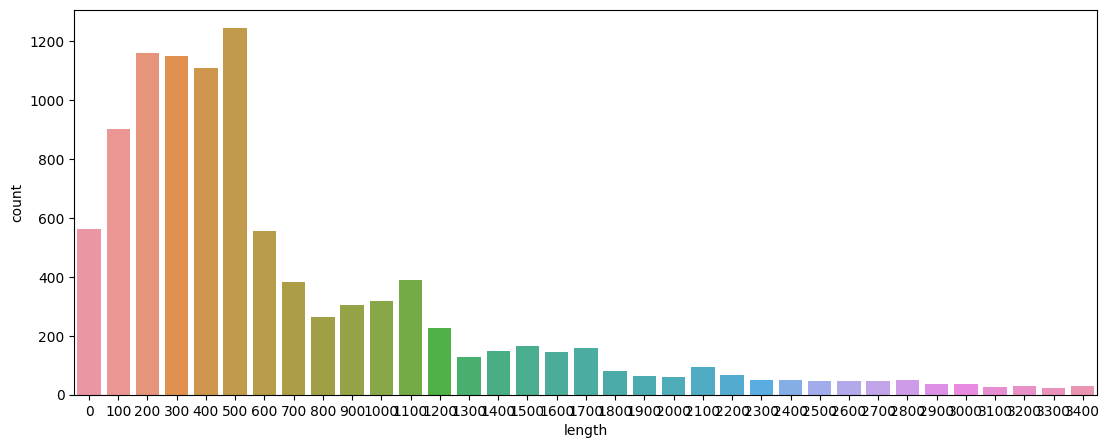

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13.2,5))
sns.countplot(data=data[data["length"] < 3500][["length"]].apply(lambda x: (x // 100) * 100), x="length", ax=ax)

In [5]:
# process topics
data["topics"] = data["topics"].replace('[\',]', '', regex=True)
for idx, row in data.iterrows():
    topics = data["topics"][idx][1:-1].split()
    data.loc[idx, "topics"] = topics[0]
    if len(topics) > 1:
        data.loc[idx, "multi-topic"] = True

data["multi-topic"] = data["multi-topic"].fillna(False)
data = data.reset_index(drop=True)
data.head()

,text,topics,length,multi-topic
0,showers continued throughout the week in the b...,cocoa,2859,False
1,the us agriculture department reported the far...,grain,1140,True
2,argentine grain board figures show crop regist...,veg-oil,1263,True
3,champion products inc said its board of direct...,earn,339,False
4,computer terminal systems inc said it has comp...,acq,1263,False


In [6]:
# only keep where we have more than 100 of the same topic
df = data[data.groupby("topics").topics.transform('count') >= 100]
df = df.reset_index(drop=True)
df.head()

,text,topics,length,multi-topic
0,the us agriculture department reported the far...,grain,1140,True
1,champion products inc said its board of direct...,earn,339,False
2,computer terminal systems inc said it has comp...,acq,1263,False
3,s hr ct s vs dlr s net vs assets m ln vs m ln ...,earn,295,False
4,ohio mattress co said its first quarter ending...,earn,784,True


Amount of data after processing: 9021


<Axes: xlabel='topics', ylabel='count'>

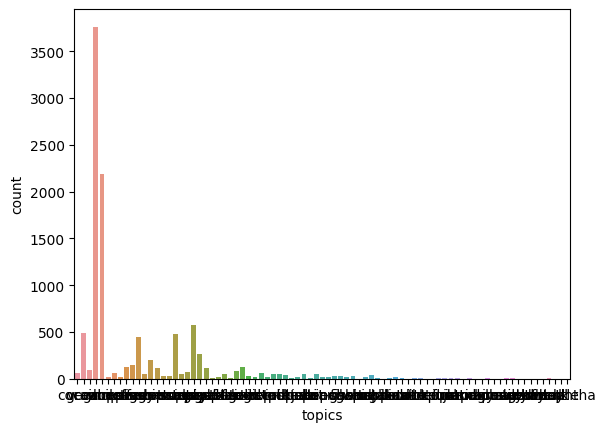

In [7]:
print(f"Amount of data after processing: {len(df)}")
sns.countplot(data=data, x="topics")

In [8]:
# prepare for model training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["topics"], test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7216,)
(1805,)
(7216,)
(1805,)


In [9]:
# encode labels²
print(X_train[0][:20])
print(y_train[0])
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.fit_transform(y_test)

# encode text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectoriser = CountVectorizer(ngram_range=(1,1))
encoded_X_train = vectoriser.fit_transform(X_train).toarray()
encoded_X_test = vectoriser.transform(X_test).toarray()
print(encded_X_train.shape)
print(encoded_X_train[0][:20])
print(encoded_y_train[0])

the us agriculture d
grain


NameError: name 'encded_X_train' is not defined

In [ ]:
# one hot encode text
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 50
max_length = df['text'].apply(len).max()
# one_hot_encoder = np.vectorize(lambda t: one_hot(t, vocab_size))
# one_hot_encoder(X_train[:2])
one_hot_X_train = [one_hot(t, vocab_size) for t in X_train]
one_hot_X_test = [one_hot(t, vocab_size) for t in X_test]

encoded_X_train = pad_sequences(one_hot_encoder_X_train, maxlen=max_length, padding="post")
encoded_X_test = pad_sequences(one_hot_encoder_X_test, maxlen=max_length, padding="post")

In [ ]:
# model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.utils import to_categorical

print(encoded_X_train.shape)
print(encoded_X_test.shape)

topics = len(df['topics'].unique())
# topics_shape = y_train.shape[1]


model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=max_length),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
model.evaluate(encoded_X_test, encoded_y_test)